# VTK - ITK Project : Etude longitudinale de l'évolution d'une tumeur

### Par Raphael Duhen, Mael Conan et Andrews Nigel

In [2]:
# Imports
import vtk
import itk
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def run_window():
    reader = vtk.vtkNrrdReader()
    reader.SetFileName("Data/case6_gre1.nrrd")
    
    window = vtk.vtkRenderWindow()
    renderer = vtk.vtkRenderer()
    
    window.AddRenderer(renderer)
    
    interactor = vtk.vtkRenderWindowInteractor()
    window.SetInteractor(interactor)
    
    contour = vtk.vtkContourFilter()
    contour.SetInputConnection(reader.GetOutputPort())
    contour.SetValue(0, 135)
    
    contourMapper = vtk.vtkPolyDataMapper()
    contourMapper.SetInputConnection(contour.GetOutputPort())
    contourMapper.ScalarVisibilityOff()
    
    contourActor = vtk.vtkActor()
    contourActor.SetMapper(contourMapper)
    
    renderer.AddActor(contourActor)
    
    window.Render()
    interactor.Start()

In [4]:
# Define types
PixelType = itk.ctype('float')
Dimension = 3
ImageType = itk.Image[PixelType, Dimension]
TransformType = itk.

In [5]:
# Load images
image = itk.imread("Data/case6_gre1.nrrd", pixel_type=PixelType)
image2 = itk.imread("Data/case6_gre2.nrrd", pixel_type=PixelType) 

In [6]:
def registration(image, image2):
    initial_transform = TransformType.New()

    # Set initial transform parameters
    initial_transform.SetRotation(0.0, 0.0, 0.0)
    initial_transform.SetTranslation(0.0)

    # Set optimizer parameters
    optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        LearningRate=4,
        MinimumStepLength=0.001,
        RelaxationFactor=0.5,
        NumberOfIterations=200,
    )

    # Set metric parameters
    metric = itk.MeanSquaresImageToImageMetricv4[ImageType, ImageType].New()

    # Set interpolator parameters
    interpolator = itk.LinearInterpolateImageFunction[ImageType, itk.D].New()

    # Set registration parameters
    registration = itk.ImageRegistrationMethodv4[ImageType, ImageType].New(
        Metric=metric,
        Optimizer=optimizer,
        InitialTransform=initial_transform,
        FixedImage=image,
        MovingImage=image2,
    )

    # Start registration
    registration.Update()

    return registration, optimizer

In [7]:
def transform_image(image, image2, registration):
    # Transform image
    transformed_image = itk.resample_image_filter(
        image2,
        transform=registration.GetTransform(),
        use_reference_image=True,
        reference_image=image,
        default_pixel_value=100,
    )

    return transformed_image

In [8]:
registration, optimizer = registration(image, image2)
transformed_image = itk.imread("Data/transformed_image.nrrd", pixel_type=PixelType)
if not transformed_image:
    transformed_image = transform_image(image, image2, registration)

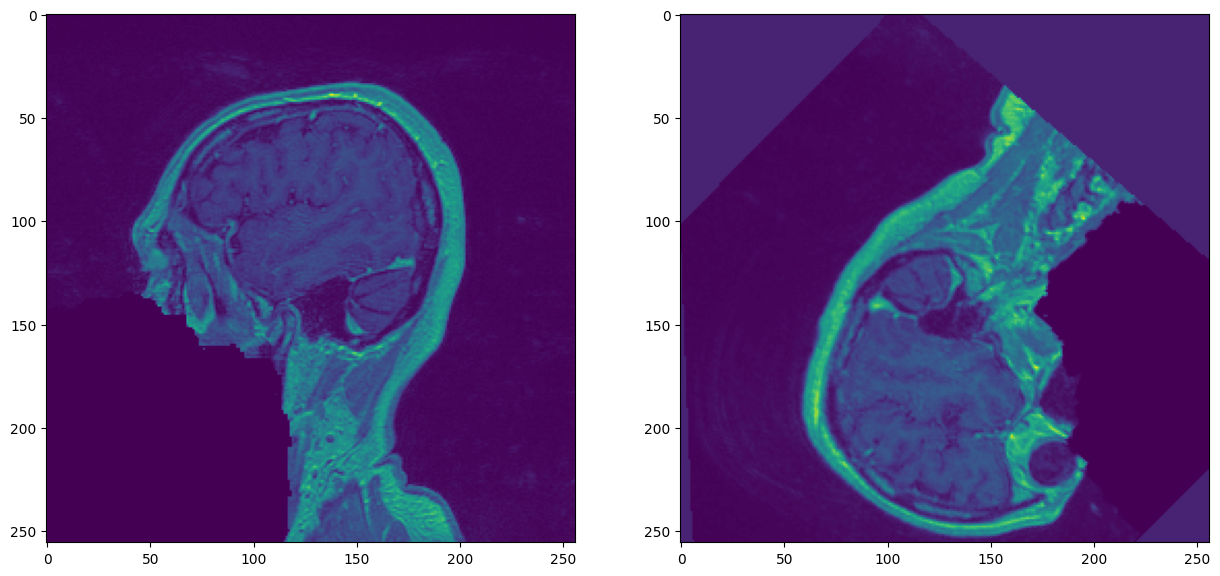

In [15]:
array_view = itk.array_view_from_image(transformed_image)
original_view = itk.array_view_from_image(image)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(original_view[135])
plt.subplot(1, 2, 2)
plt.imshow(array_view[135])
plt.show()

In [9]:
# Save image
itk.imwrite(transformed_image, "Data/transformed_image.nrrd")

In [12]:
# Get final parameters
final_parameters = registration.GetOutput().Get().GetParameters()

# # Get final metric value
# final_metric_value = registration.GetMetricValue()

# Get final number of iterations
final_number_of_iterations = optimizer.GetCurrentIteration()

# Print results
print("Result = ", final_parameters)
# print("Metric value = ", final_metric_value)
print("Number of iterations = ", final_number_of_iterations)

Result =  <itk.itkOptimizerParametersPython.itkOptimizerParametersD; proxy of <Swig Object of type 'itkOptimizerParametersD *' at 0x15e46c360> >
Number of iterations =  200
